In [2]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, haswell)
  Threads: 2 on 32 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/cuda-10.1/lib64::/.singularity.d/libs
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


- https://github.com/FluxML/Flux.jl
- http://fluxml.ai/Flux.jl/stable/

In [3]:
# set the output format of gr backend to png. default is svg, which maldisplays in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

#@time using StatsPlots; 
#@time gr(fmt = :png)

  0.000222 seconds (140 allocations: 13.141 KiB)
  0.000110 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [8]:
@time using Flux, Statistics, ProgressMeter, Random;
@time using DataFrames, CSV;

  0.000371 seconds (533 allocations: 51.359 KiB)
  0.000164 seconds (271 allocations: 25.883 KiB)


In [9]:
# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
Random.seed!(12)
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}
println("$(sum(truth))/$(length(truth)) is of class 1.")
#println(Fmt"{x}/{y} is of class 1.", x = sum(truth), y = length(truth) )

468/1000 is of class 1.


In [10]:
# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
@time out1 = model(noisy |> gpu) |> cpu # 2×1000 Matrix{Float32}, first row is prob(true), second row p(false)
display(out1)


┌ Info: The CUDA functionality is being called but
│ `CUDA.jl` must be loaded to access it.
└ Add `using CUDA` or `import CUDA` to your code.


  3.114251 seconds (4.94 M allocations: 327.654 MiB, 7.97% gc time, 99.95% compilation time)


2×1000 Matrix{Float32}:
 0.655858  0.67685  0.669608  0.583055  …  0.611154  0.661057  0.6284
 0.344142  0.32315  0.330392  0.416945     0.388845  0.338942  0.3716

LoadError: LoadError: UndefVarError: `@f_str` not defined
in expression starting at In[10]:13

In [19]:
# accuracy with an untrained network
#println(Fmt.format(f"The accuracy with an untrained network is {x}", x=mean((out1[1,:] .> 0.5) .== truth) ) ) 
println("The accuracy with an untrained network is $(x=mean((out1[1,:] .> 0.5) .== truth))" ) 

The accuracy with an untrained network is 0.446


In [11]:
model

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

In [12]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

In [13]:
optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
loss_v = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(loss_v, loss)  # logging, outside gradient context
    end
end

display(optim) # parameters, momenta and output have all changed

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


(layers = ((weight = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.016913 -0.0185758; 0.0204945 0.00905094; 0.00286861 0.0518106], Float32[0.0104792 0.411874; 0.0198885 0.00879092; 0.0114881 0.00972175], (6.0f-45, 1.11549f-7))), bias = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.00460741, -0.00580345, 0.0610408], Float32[0.00100443, 0.035997, 0.0381049], (6.0f-45, 1.11549f-7))), σ = ()), (λ = (), β = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.102295, -0.0863599, 0.0755937], Float32[0.0515409, 0.0378912, 0.0302529], (6.0f-45, 1.11549f-7))), γ = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0633513, -0.0461668, -0.0214505], Float32[0.0149125, 0.0167216, 0.0133949], (6.0f-45, 1.11549f-7))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0396911 0.0292039 -0.0230708; -0.0396911 -0.0292039 0.0230708], Float32[0.00505428 0.00765795 0.0129384; 0.00505428 0.00765795 

In [18]:
# prediction
@time out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)

# println(Fmt.format(f"The accuracy is {x}", x=mean((out2[1,:] .> 0.5) .== truth) ) )  # accuracy 94% so far!
println("The accuracy is $(x=mean((out2[1,:] .> 0.5) .== truth))" )  # accuracy 94% so far!

  0.000155 seconds (22 allocations: 64.516 KiB)
The accuracy is 0.95


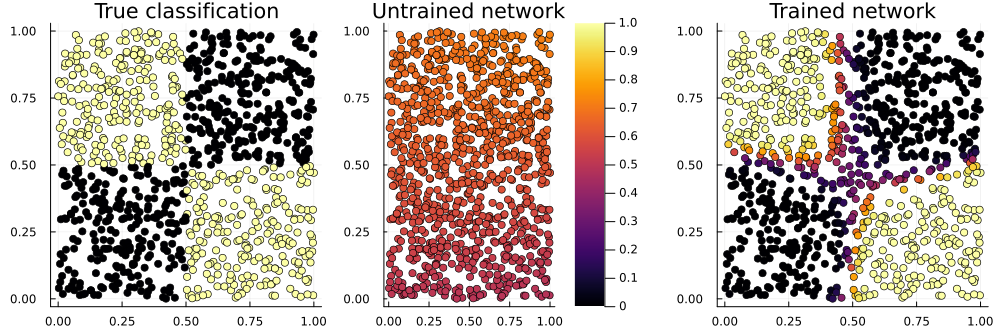

In [15]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

  0.321330 seconds (412.36 k allocations: 25.942 MiB, 98.85% compilation time: 1% of which was recompilation)


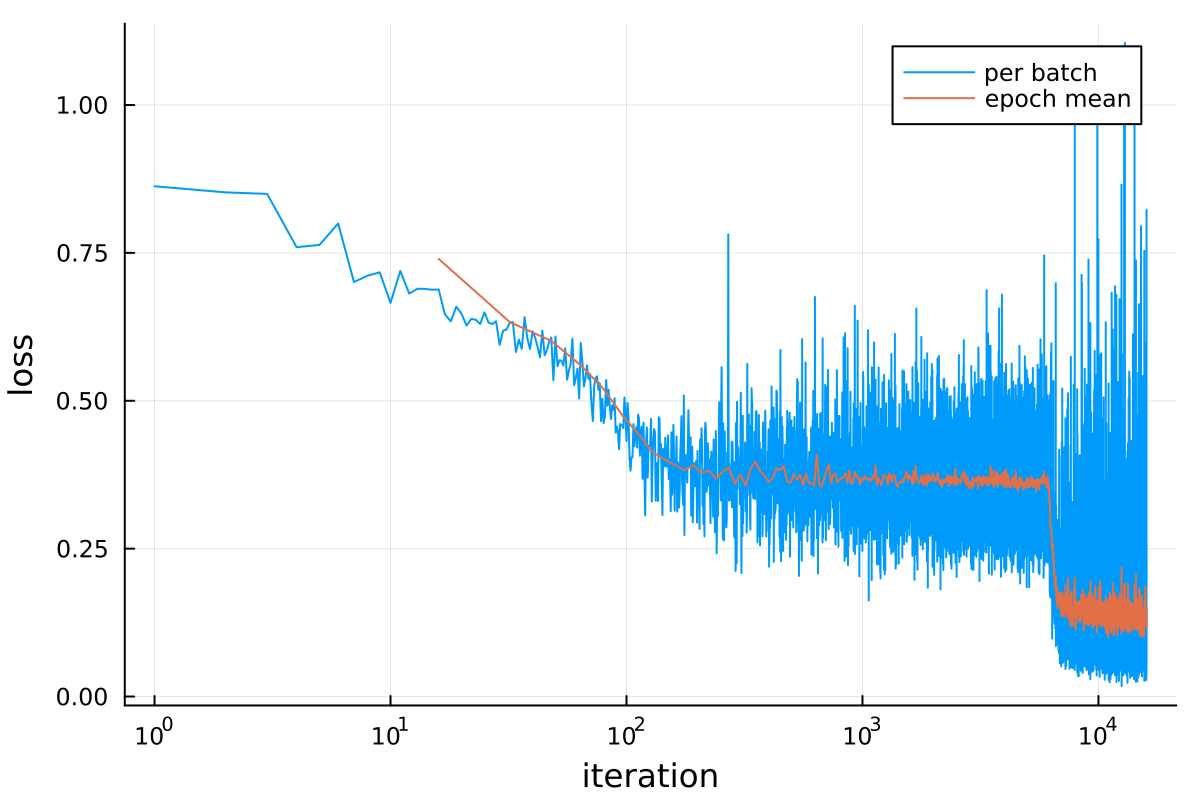

In [16]:
plot(loss_v; xaxis=(:log10, "iteration"), yaxis="loss", label="per batch")
n = length(loader)
@time plot!(n:n:length(loss_v), mean.(Iterators.partition(loss_v, n)), label="epoch mean", dpi=200)